In [1]:
import os, sys, math, datetime
import psutil
#import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from dotenv import load_dotenv
import boto3
import wandb
from wandb.keras import WandbCallback
import mlflow
import deeplake


d:\Miniconda\envs\tiny_cnn\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.0.13) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
models_dir = Path.cwd().joinpath("models")
if not models_dir.exists():
    print(f"{models_dir} does not exist.")
    models_dir.mkdir()
    print(f"Created path: {models_dir}.")


In [4]:
input_shape =(96,96,1)
classes = 2
alpha = 0.25

In [5]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(
    input_shape=input_shape,
    alpha=alpha,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None, #'imagenet'
    input_tensor=None,
    pooling=None,
    classes=classes,
    classifier_activation='softmax',
    #**kwargs
)

In [6]:
model = mobilenet
model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [7]:
summary = model.summary(expand_nested=True)

Model: "mobilenet_0.25_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 8)         72        
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 48, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 8)        72        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 48, 8)        32        
 ation)                                          

mobilenet_0.25_96


In [8]:
# generate folder structure for saving the models
channels = input_shape[-1]
print(channels)


1


In [9]:
model_name = model.name
model_name = f"{model_name}_c{channels}"
print(model_name)


mobilenet_0.25_96_c1


In [17]:
models_path = models_dir.joinpath(model_name)
if not models_path.exists():
    print(f"{models_path} does not exist.")
    models_path.mkdir()
    print(f"Created path: {models_path}.")

models_summary_path = models_dir.joinpath(model_name, f"{model_name}.txt")
models_image_path = models_dir.joinpath(model_name, f"{model_name}.png")
print(models_summary_path)
models_tflite_path = models_dir.joinpath(model_name, f"{model_name}.tflite")
models_tflite_opt_path = models_dir.joinpath(model_name, f"{model_name}_INT8.tflite")
print(models_tflite_path)

i:\tinyml\tiny_cnn\models\mobilenet_0.25_96_c1\mobilenet_0.25_96_c1.txt
i:\tinyml\tiny_cnn\models\mobilenet_0.25_96_c1\mobilenet_0.25_96_c1.tflite


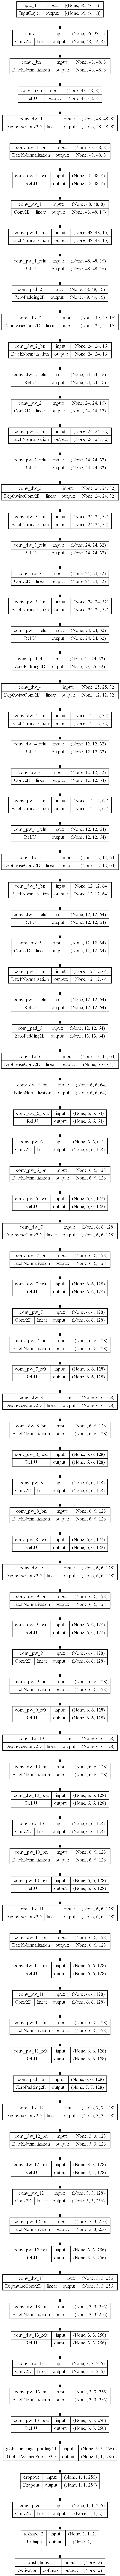

In [11]:
tf.keras.utils.plot_model(model, 
    to_file=models_image_path,
    show_shapes=True, 
    show_dtype=False,
    show_layer_names=True, 
    rankdir='TB', # TB for vertical plot, LR for horizontal plot
    expand_nested=True, 
    layer_range=None,
    dpi=200,
    show_layer_activations= True)

In [19]:
my_json = model.to_json()

In [59]:
# from tensorflow.keras.models import Model
# def  Mymodel(backbone_model, classes):
#     backbone = backbone_model
#     x = backbone.output
#     x = tf.keras.layers.Dense(classes,activation='sigmoid')(x)
#     model = Model(inputs=backbone.input, outputs=x)
#     return model

# input_shape = (224, 224, 3)
# model = Mymodel(backbone_model=tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False, pooling='avg'),
#                 classes=61)

# model.summary()

In [12]:
from contextlib import redirect_stdout

with open(models_summary_path, 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [13]:
model.save(models_path)

INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\models\mobilenet_0.25_96_c1\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\models\mobilenet_0.25_96_c1\assets


In [14]:
reconstructed_model = keras.models.load_model(models_path)

# Let's check:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(test_input, test_target)

# Conversion to TFLite

In [15]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(models_tflite_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpycoih5oj\assets


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpycoih5oj\assets


In [20]:
# repr_ds = test_ds.unbatch()

# def representative_data_gen():
#   for i_value, o_value in repr_ds.batch(1).take(48):
#     yield [i_value]
converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)
#converter_opt = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
# converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
#converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter_opt.inference_input_type = tf.int8

tflite_model_opt = converter_opt.convert()

# Save the model.
with open(models_tflite_opt_path, 'wb') as f:
  f.write(tflite_model_opt)

INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmp9llu7w3e\assets


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmp9llu7w3e\assets


In [21]:
models_tflite_opt_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenet_0.25_96_c1/mobilenet_0.25_96_c1_INT8.tflite')

### Convert the TFLite model to C-byte array with xxd

In [16]:
total_bytes = psutil.virtual_memory()[3]
MB = total_bytes/(1024*1024)
print(MB)

13932.7890625


In [24]:
converter.

TypeError: 'TFLiteConverterMetrics' object is not callable

In [18]:
tflite_size = tflite_model.flatbuffer_size

AttributeError: 'bytes' object has no attribute 'flatbuffer_size'

In [38]:
for layer in model.layers:
    print(layer.name, layer.compute_dtype ,len(layer.variables) , layer.input_shape, layer.output_shape)

input_1 float32 0 [(None, 96, 96, 3)] [(None, 96, 96, 3)]
conv1 float32 1 (None, 96, 96, 3) (None, 48, 48, 8)
conv1_bn float32 4 (None, 48, 48, 8) (None, 48, 48, 8)
conv1_relu float32 0 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1 float32 1 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1_bn float32 4 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1_relu float32 0 (None, 48, 48, 8) (None, 48, 48, 8)
conv_pw_1 float32 1 (None, 48, 48, 8) (None, 48, 48, 16)
conv_pw_1_bn float32 4 (None, 48, 48, 16) (None, 48, 48, 16)
conv_pw_1_relu float32 0 (None, 48, 48, 16) (None, 48, 48, 16)
conv_pad_2 float32 0 (None, 48, 48, 16) (None, 49, 49, 16)
conv_dw_2 float32 1 (None, 49, 49, 16) (None, 24, 24, 16)
conv_dw_2_bn float32 4 (None, 24, 24, 16) (None, 24, 24, 16)
conv_dw_2_relu float32 0 (None, 24, 24, 16) (None, 24, 24, 16)
conv_pw_2 float32 1 (None, 24, 24, 16) (None, 24, 24, 32)
conv_pw_2_bn float32 4 (None, 24, 24, 32) (None, 24, 24, 32)
conv_pw_2_relu float32 0 (None, 24, 24, 32) (None, 24, 24, 32